<a href="https://colab.research.google.com/github/Yuumna/ECEN501-project-Breast-Cancer-Detection-/blob/master/DT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"yumnaali","key":"c1c730ac95b46295881495fbdd688b05"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d uciml/breast-cancer-wisconsin-data

breast-cancer-wisconsin-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
from zipfile import ZipFile
file_name= "breast-cancer-wisconsin-data.zip" 
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [0]:
import pandas as pd
data=pd.read_csv('data.csv')

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

Number of Benign:  357
Number of Malignant :  212


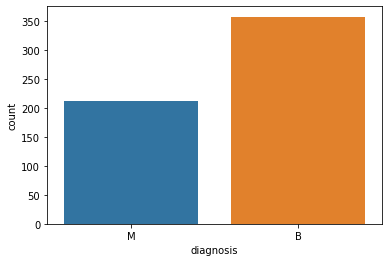

In [0]:
y = data.diagnosis                          # M or B 
ax = sns.countplot(y,label="Count")       # M = 212, B = 357
B, M = y.value_counts()
print('Number of Benign: ',B)
print('Number of Malignant : ',M)

In [0]:
# removing id and unnamed: 32 column which is not necessary for our model
data = data.drop(['id','Unnamed: 32'],axis = 1)

In [0]:
# Mapping our target variable to 1 and 0
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['diagnosis'] = le.fit_transform(data['diagnosis'])

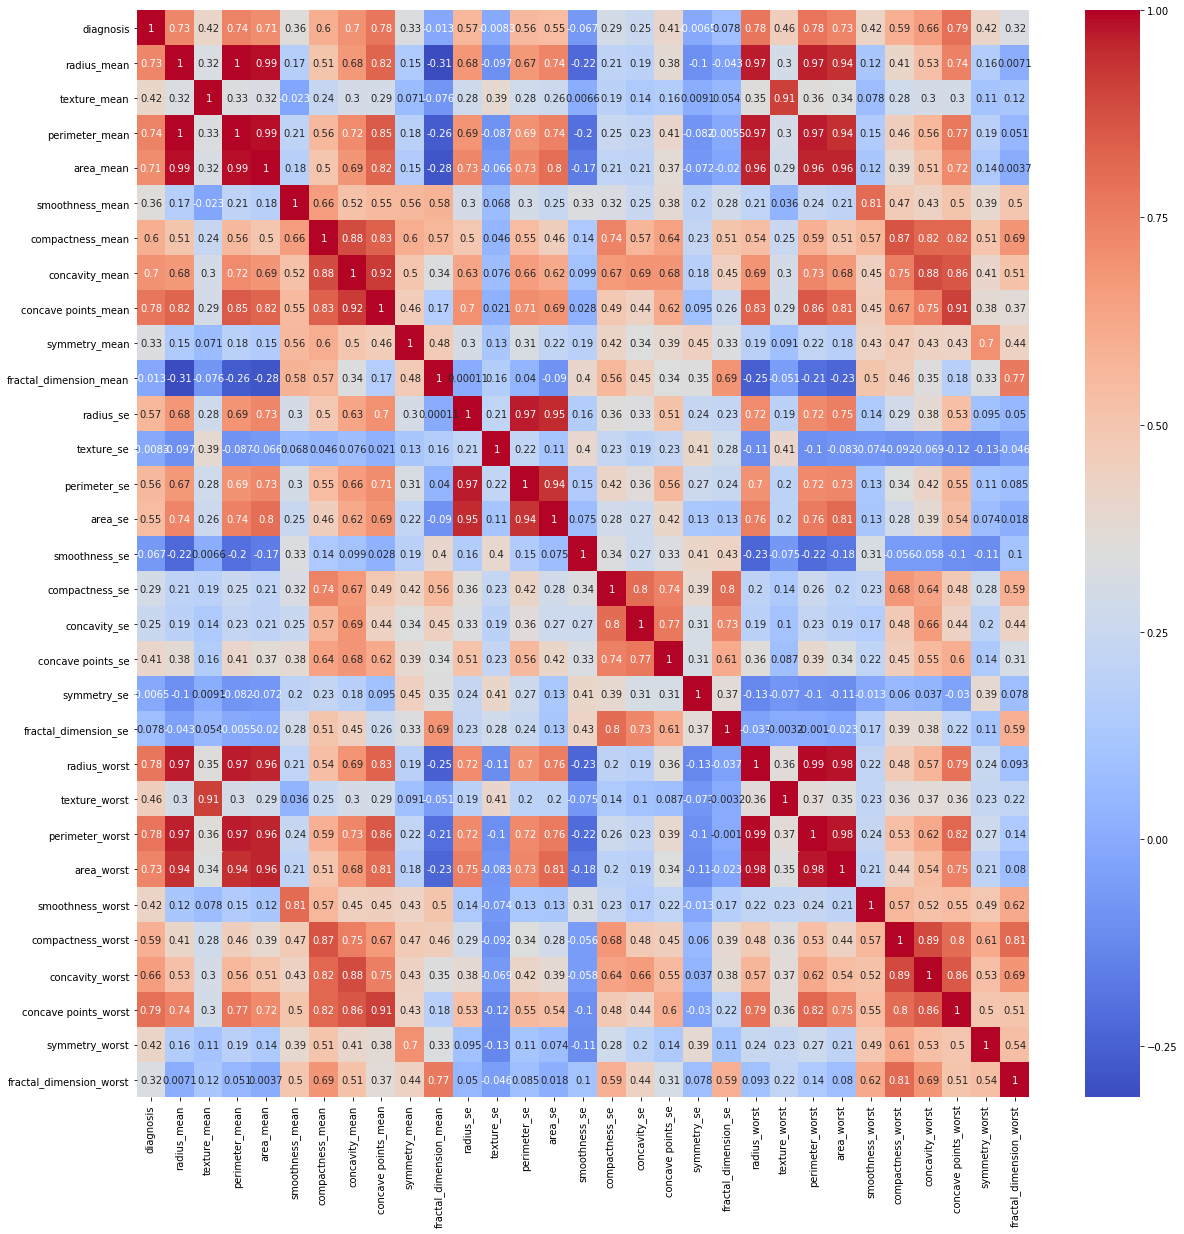

In [0]:
# Finding correlation among features using sns' heatmap
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(),annot=True,cmap='coolwarm')

In [0]:
# removing features that are less correlated with our target variable
data.corr().diagnosis[data.corr().diagnosis<=0.2]

fractal_dimension_mean   -0.012838
texture_se               -0.008303
smoothness_se            -0.067016
symmetry_se              -0.006522
fractal_dimension_se      0.077972
Name: diagnosis, dtype: float64

In [0]:
less_corr = data.corr().diagnosis[data.corr().diagnosis<=0.2].index
data = data.drop(less_corr,axis=1)
data.shape

(569, 26)

In [0]:
# Standardizing our features except target variable
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
#only the specified columns in transformers are transformed and combined in the output,
stand_scale = data.drop(['diagnosis'],axis = 1)
#all remaining columns that were not specified in transformers will be automatically passed through
col_trans = make_column_transformer(
            (StandardScaler(), stand_scale.columns),
            remainder = 'passthrough')


NameError: ignored

In [0]:
from sklearn.model_selection import train_test_split
X = data.drop(['diagnosis'], axis = 1)
y = data['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
col_trans.fit_transform(X_train)

array([[-1.15036482, -0.39064196, -1.12855021, ..., -0.75798367,
        -0.01614761, -0.38503402],
       [-0.93798972,  0.68051405, -0.94820146, ..., -0.60687023,
         0.09669004, -0.38615797],
       [ 0.574121  , -1.03333557,  0.51394098, ..., -0.02371948,
        -0.20050207, -0.75144254],
       ...,
       [-1.32422924, -0.20048168, -1.31754581, ..., -0.97974953,
        -0.71542314, -0.11978123],
       [-1.24380987, -0.2245526 , -1.28007609, ..., -1.75401433,
        -1.58157125, -1.00601779],
       [-0.73694129,  1.14989702, -0.71226578, ..., -0.27460457,
        -1.25895095,  0.21515662]])

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn import metrics
dt_scores = []
for i in range(1, len(X.columns) + 1):
    dt_classifier = DecisionTreeClassifier(max_features = i, random_state = 0)
    pipe = make_pipeline(col_trans,dt_classifier)
    dt_scores.append(cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0.5, 1.0, 'Decision Tree Classifier scores for different number of maximum features')

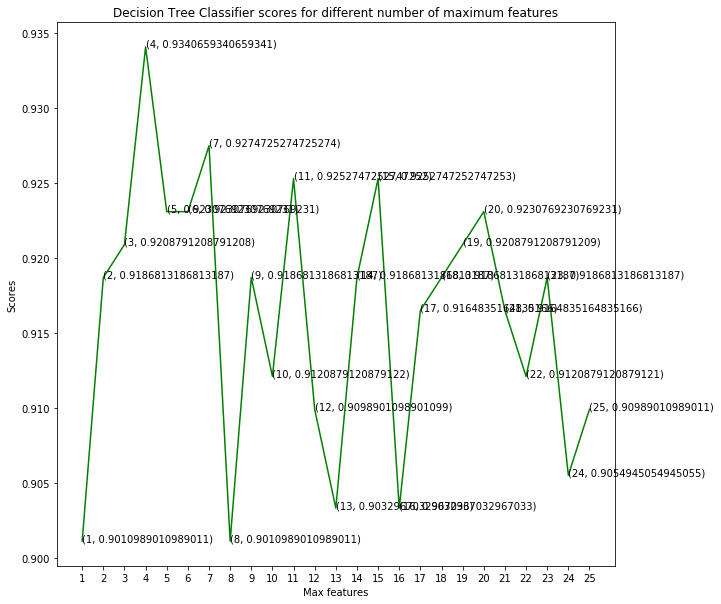

In [0]:
plt.figure(figsize=(10,10))
plt.plot([i for i in range(1, len(X.columns) + 1)], dt_scores, color = 'green')
for i in range(1, len(X.columns) + 1):
    plt.text(i, dt_scores[i-1], (i, dt_scores[i-1]))
plt.xticks([i for i in range(1, len(X.columns) + 1)])
plt.xlabel('Max features')
plt.ylabel('Scores')
plt.title('Decision Tree Classifier scores for different number of maximum features')

In [0]:
print('Accuracy score on Train data: {}'.format(dt_scores[3]*100))

Accuracy score on Train data: 93.4065934065934


In [0]:
dt_classifier = DecisionTreeClassifier(max_features = 4, random_state = 0)
pipe = make_pipeline(col_trans,dt_classifier)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('Accuracy  score on Test data: {}'.format(metrics.accuracy_score(y_test,y_pred)*100))

Accuracy  score on Test data: 94.73684210526315


In [0]:
print('Confusion Matrix - Training Dataset')
print(pd.crosstab(y_train, pipe.predict(X_train), rownames = ['True'], colnames = ['Predicted'], margins = True))

Confusion Matrix - Training Dataset
Predicted    0    1  All
True                    
0          290    0  290
1            0  165  165
All        290  165  455


In [0]:
print('Confusion Matrix - Testing Dataset')
print(pd.crosstab(y_test, y_pred, rownames = ['True'], colnames = ['Predicted'], margins = True))

Confusion Matrix - Testing Dataset
Predicted   0   1  All
True                  
0          63   4   67
1           2  45   47
All        65  49  114


In [0]:
from sklearn.metrics import precision_score,recall_score,f1_score
print('Precision Score: {}'.format(precision_score(y_test,y_pred)));
print('Recall Score: {}'.format(recall_score(y_test,y_pred)))

Precision Score: 0.9183673469387755
Recall Score: 0.9574468085106383
